In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

In [2]:
def locally_sparse_noise(matrix_shape, min_distance, min_distance_bw_frames, num_squares):
    """
    Base function to generate locally sparse noise (LSN) matrix.
    
    Parameters
    ----------
    matrix_shape: [int, int]
        height and width
    min_distance: int
        Minimum distance allowed between the center of squares
    min_distance_bw_frames: int
        Minimum distance allowed between consecutive frames
    num_squares: int
        Number of squares in one frame
    
    Returns
    -------
    mat: 2D array
    mat.shape[0] will be approximately (matrix_shape[0]*matrix_shape[1]/num_squares) but this is stochastic
    mat.shape[1] will be 2, corresponding to the 2D indices of the square positions
    """
    x = np.arange(matrix_shape[1])
    y = np.arange(matrix_shape[0])
    bag = np.array(np.meshgrid(y, x)).T.reshape(-1,2)
    bag_indices = np.arange(bag.shape[0])

    mat = []
    exit_loop = False
    prev = np.array([[1e10, 1e10]])
    while True:
        # get first element from the bag
        i = np.random.choice(bag_indices)
        out = np.array([bag[i]])
        bag_indices= np.delete(bag_indices, (bag_indices==i).argmax())
        count = 0
        while True:
            count += 1
            # get the next element from the bag
            i = np.random.choice(bag_indices)
            n = bag[i]
            dist1 = np.sqrt((n[0] - out[:,0])**2 + (n[1]- out[:,1])**2)
            dist2 = np.sqrt((n[0] - prev[:,0])**2 + (n[1]- prev[:,1])**2)
            if dist1.min() > min_distance and dist2.min() > min_distance_bw_frames:
                out = np.concatenate((out, [n]), axis=0)
                bag_indices = np.delete(bag_indices, (bag_indices==i).argmax())
            if out.shape[0] >= num_squares:
                prev = out.copy()
                break
            if count > 10000:
                # if you cannot find a good pair in 100 attempts, there is no more possible combinations, so exit the loop
                exit_loop = True
                break
        if exit_loop:
            break
        else:
            mat.append(out)
        if bag_indices.size < num_squares:
            # if bag is almost empty, exit the loop
            break
    return np.array(mat)

In [3]:
def main(monitor_pixel_dims, monitor_real_width, distance_to_monitor, unit_degree, num_squares, min_square_distance_degree, num_repeats, occupancy=0.98):
    """
    Main function
    """
    C = monitor_real_width/2
    A = distance_to_monitor
    B = np.sqrt((A**2)+(C**2))
    w = ((B**2)+(B**2)-monitor_real_width**2)/(2*(B**2))
    W = np.rad2deg(np.arccos(w))
    print("Total viewing angle (horizontal)", W)
    
    unit_pixels = np.floor(monitor_pixel_dims[1]/W*unit_degree)
    matrix_shape = np.array(monitor_pixel_dims)/unit_pixels
    matrix_shape = np.floor(matrix_shape).astype("int")
    min_square_distance_pixels = min_square_distance_degree / unit_degree
    print("Unit pixels:", unit_pixels)
    print("Output matrix size:", matrix_shape)
    print("Min square distance in pixels", min_square_distance_pixels)

    g = []
    c = 0
    running_sum = np.zeros(matrix_shape)
    while True:
        if len(g) >= num_repeats:
            break
        c += 1
        if c > 3000:
            raise ValueError("FAILED TO FIND MATRIX!")
        m = locally_sparse_noise(matrix_shape, min_square_distance_pixels, int(min_square_distance_pixels/2), num_squares)
        chosen = m.copy().reshape(-1, 2)
        if len(g) == 0:
            lowest = np.array([[0,0]])
        else:
            lowest = np.dstack(np.where(running_sum == running_sum.min()))[0]
        if m.shape[0] > matrix_shape[0] * matrix_shape[1] / num_squares * occupancy:
            if np.all(lowest[:, None] == chosen, axis=2).any(axis=1).sum() > lowest.shape[0] * 0.99:
                g.append(m)
                print(m.shape[0])
                for i in range(len(m)):
                    running_sum[m[i][:,0], m[i][:,1]] += 1
                c = 0

    for i in range(len(g)):
        if i == 0:
            G = g[0]
        else:
            G = np.concatenate((G, g[i]), axis=0)

    return G, matrix_shape

## Compute the locally sparse grid (8 degree)

In [10]:
monitor_pixel_dims = [720, 1280] # pixels; height x width
monitor_real_width = 19.2 # cm
distance_to_monitor = 7.0 # cm
unit_degree = 8.0 # degrees
min_square_distance_degree = 16 # degrees
num_squares = 6
num_repeats = 20

M, mat_shape = main(monitor_pixel_dims, monitor_real_width, distance_to_monitor, unit_degree, num_squares, min_square_distance_degree, num_repeats)

print(M.shape, mat_shape)

Total viewing angle (horizontal) 107.803432065784
Unit pixels: 94.0
Output matrix size: [ 7 13]
Min square distance in pixels 2.0
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
(300, 6, 2) [ 7 13]


20.0
19.78021978021978
19.0
20


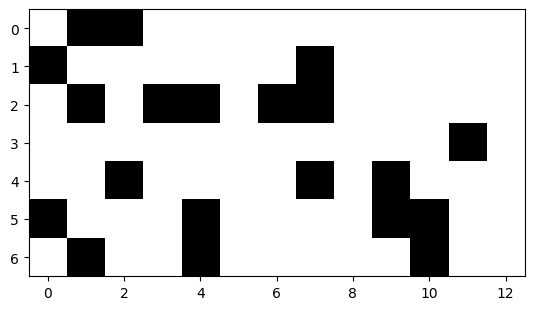

In [6]:
### Check 1: Show the sum of all frames

img = np.zeros(mat_shape)
for i in range(len(M)):
    img[M[i][:,0], M[i][:,1]] += 1

print(img.max())
print(img.mean())
print(img.min())
print((img==img.min()).sum())
plt.imshow(img, cmap="gray", vmin=img.min(), vmax=img.max())

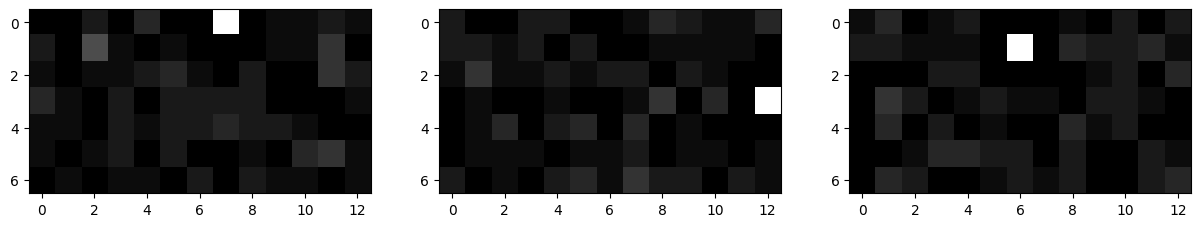

In [7]:
### Check 2: Show the activation of a given index

fig, axs = plt.subplots(1,3, figsize=(15,5))
for j in range(3):
    ny = np.random.choice(7)
    nx = np.random.choice(13)
    out = np.zeros(mat_shape)
    for i in range(len(M)):
        img = np.zeros(mat_shape)
        img[M[i][:,0], M[i][:,1]] += 1
        if img[ny, nx] == 1:
            out += img
    out = out / out.max()
    axs[j].imshow(out, cmap="gray", vmin=0, vmax=1)
plt.show()

In [8]:
### Generate the matrix (square size = 4 degrees)

lsn_mat = []
for i in range(len(M)):
    img = np.zeros(mat_shape)
    img[M[i][:,0], M[i][:,1]] += 1
    lsn_mat.append(img)
lsn_mat = np.array(lsn_mat)

# make half of the squares white and the other half black
for ny in range(lsn_mat.shape[1]):
    for nx in range(lsn_mat.shape[2]):
        col = lsn_mat[:, ny, nx]
        idx = np.where(col==1)
        black_idx = np.random.choice(idx[0], (int(idx[0].size/2)), replace=False)
        lsn_mat[black_idx, ny, nx] = -1

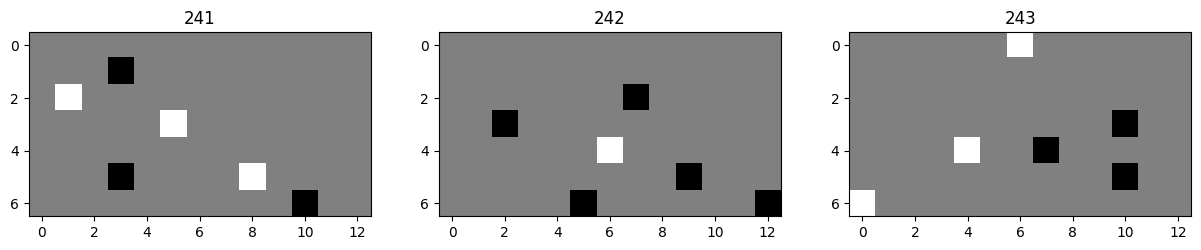

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
i = np.random.choice(lsn_mat.shape[0])
for j in range(3):
    img = lsn_mat[i+j]
    axs[j].imshow(img, cmap="gray", vmin=-1, vmax=1)
    axs[j].set_title(str(i+j))
plt.show()

In [11]:
np.save('LSN_8DEG.npy', lsn_mat, allow_pickle=True)

### Copy result to bucket

In [12]:
print("cp LSN_4DEG.npy /bucket/ReiterU/OLdev/experiments/visual_stim/20241024_LSN_matrix/")

cp LSN_4DEG.npy /bucket/ReiterU/OLdev/experiments/visual_stim/20241024_LSN_matrix/
